In [1]:
# Cell 1: Import dan konfigurasi awal (versi untuk Kaggle)
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report

# konfigurasi dasar
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# path dataset di Kaggle
# struktur dataset: /kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/*.png
#                   /kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/*.png
dataset_dir = "/kaggle/input/cell-images-for-detecting-malaria/cell_images"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4

# cek GPU
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("Dataset directory:", os.listdir(dataset_dir))

2025-11-01 18:42:13.361681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762022533.397159      89 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762022533.403973      89 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dataset directory: ['Uninfected', 'Parasitized', 'cell_images']


In [2]:
# Cell 2: Membuat dataframe dari folder dataset (versi untuk Kaggle)
import os
import pandas as pd

filepaths = []
labels = []

# Loop untuk membuat dataframe
for class_name in ["Parasitized", "Uninfected"]:
    class_folder = os.path.join(dataset_dir, class_name)
    # pastikan folder ada
    if not os.path.exists(class_folder):
        print(f"Folder tidak ditemukan: {class_folder}")
        continue

    for fname in os.listdir(class_folder):
        fpath = os.path.join(class_folder, fname)
        # pastikan benar-benar file gambar
        if os.path.isfile(fpath) and fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepaths.append(fpath)
            labels.append(class_name)

# buat dataframe
df = pd.DataFrame({"filepath": filepaths, "label": labels})
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

print("Jumlah total gambar:", len(df))
print(df['label'].value_counts())
print("\nContoh data:")
print(df.head())

Jumlah total gambar: 27558
label
Parasitized    13779
Uninfected     13779
Name: count, dtype: int64

Contoh data:
                                            filepath        label
0  /kaggle/input/cell-images-for-detecting-malari...  Parasitized
1  /kaggle/input/cell-images-for-detecting-malari...  Parasitized
2  /kaggle/input/cell-images-for-detecting-malari...   Uninfected
3  /kaggle/input/cell-images-for-detecting-malari...   Uninfected
4  /kaggle/input/cell-images-for-detecting-malari...   Uninfected


In [3]:
# Cell 3: Split data (versi untuk Kaggle)
from sklearn.model_selection import train_test_split

# Split data dengan stratifikasi agar seimbang
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=SEED
)

train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df['label'], random_state=SEED
)

print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

# tampilkan distribusi label untuk memastikan pembagian seimbang
print("\nDistribusi label:")
print("Train:\n", train_df['label'].value_counts())
print("\nValidation:\n", val_df['label'].value_counts())
print("\nTest:\n", test_df['label'].value_counts())

# tampilkan contoh beberapa baris
print("\nContoh data train:")
print(train_df.head())

Train: 17636
Validation: 4410
Test: 5512

Distribusi label:
Train:
 label
Parasitized    8818
Uninfected     8818
Name: count, dtype: int64

Validation:
 label
Uninfected     2205
Parasitized    2205
Name: count, dtype: int64

Test:
 label
Uninfected     2756
Parasitized    2756
Name: count, dtype: int64

Contoh data train:
                                                filepath        label
22346  /kaggle/input/cell-images-for-detecting-malari...  Parasitized
17793  /kaggle/input/cell-images-for-detecting-malari...   Uninfected
5938   /kaggle/input/cell-images-for-detecting-malari...   Uninfected
20210  /kaggle/input/cell-images-for-detecting-malari...  Parasitized
15309  /kaggle/input/cell-images-for-detecting-malari...  Parasitized


In [4]:
# Cell 4: ImageDataGenerator (augmentasi dan normalisasi) - versi untuk Kaggle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=[0.8, 1.0],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalisasi untuk validasi dan testing (tanpa augmentasi)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator training
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    dtype='float32'
)

# Generator validation
val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False,
    dtype='float32'
)

# Generator testing
test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False,
    dtype='float32'
)

print("\nClass indices mapping:")
print(train_gen.class_indices)

print(f"\nTotal batch (train): {len(train_gen)}")
print(f"Total batch (val): {len(val_gen)}")
print(f"Total batch (test): {len(test_gen)}")

Found 17636 validated image filenames belonging to 2 classes.
Found 4410 validated image filenames belonging to 2 classes.
Found 5512 validated image filenames belonging to 2 classes.

Class indices mapping:
{'Parasitized': 0, 'Uninfected': 1}

Total batch (train): 552
Total batch (val): 138
Total batch (test): 173


In [5]:
# Cell 5: Model VGG16 (versi untuk Kaggle)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Gunakan VGG16 pretrained dari ImageNet tanpa fully connected layer (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze semua layer convolutional agar tidak ikut dilatih
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan layer kustom untuk klasifikasi malaria
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Bentuk model akhir
model = Model(inputs=base_model.input, outputs=outputs)

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=LR),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Tampilkan ringkasan model dan status GPU
print("Model siap untuk training di Kaggle environment.")
print("GPU Available:", tf.config.list_physical_devices('GPU'))
model.summary()

I0000 00:00:1762022641.315828      89 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model siap untuk training di Kaggle environment.
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
# Cell 6: Training dan waktu eksekusi (versi untuk Kaggle)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import time

# Simpan model terbaik ke folder /kaggle/working agar bisa diunduh dari tab "Output"
checkpoint_path = "/kaggle/working/best_vgg16_malaria.h5"
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("Mulai training model...")
start_time = time.time()

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, reduce_lr, early_stop],
    verbose=1
)

end_time = time.time()
print(f"\nWaktu training total: {end_time - start_time:.2f} detik")
print(f"Model terbaik disimpan di: {checkpoint_path}")

Mulai training model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1762022649.040925     140 service.cc:148] XLA service 0x7ad0d400d300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762022649.042058     140 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762022649.531288     140 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/552 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.4219 - loss: 0.8008   

I0000 00:00:1762022658.013214     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.5815 - loss: 0.6728
Epoch 1: val_accuracy improved from -inf to 0.79569, saving model to /kaggle/working/best_vgg16_malaria.h5
552/552 ━━━━━━━━━━━━━━━━━━━━ 338s 592ms/step - accuracy: 0.5817 - loss: 0.6727 - val_accuracy: 0.7957 - val_loss: 0.5456 - learning_rate: 1.0000e-04
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.7650 - loss: 0.5300
Epoch 2: val_accuracy improved from 0.79569 to 0.81973, saving model to /kaggle/working/best_vgg16_malaria.h5
552/552 ━━━━━━━━━━━━━━━━━━━━ 196s 356ms/step - accuracy: 0.7650 - loss: 0.5300 - val_accuracy: 0.8197 - val_loss: 0.4643 - learning_rate: 1.0000e-04
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8193 - loss: 0.4513
Epoch 3: val_accuracy improved from 0.81973 to 0.83515, saving model to /kaggle/working/best_vgg16_malaria.h5
552/552 ━━━━━━━━━━━━━━━━━━━━ 196s 355ms/step - accuracy: 0.8193 - loss: 0.4512 - val_accuracy: 0.8351 - val_loss: 0.4103 -

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


173/173 ━━━━━━━━━━━━━━━━━━━━ 50s 284ms/step
Confusion Matrix:
 [[2191  565]
 [  85 2671]]
Accuracy: 0.8821
Precision: 0.8254
Recall: 0.9692
F1 Score: 0.8915
AUC/ROC: 0.9628


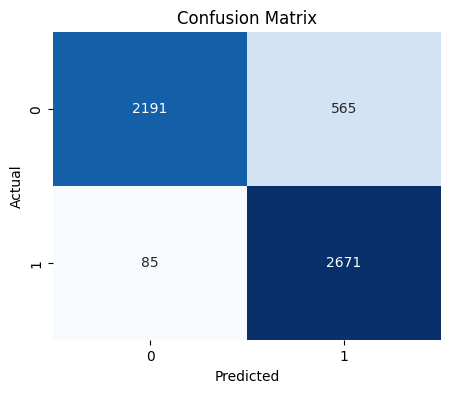

In [7]:
# Cell 7: Evaluasi pada data test

from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi probabilitas dan label
y_prob = model.predict(test_gen, verbose=1)
y_pred = (y_prob > 0.5).astype(int).flatten()
y_true = test_gen.classes

# Hitung metrik evaluasi
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
auc = roc_auc_score(y_true, y_prob)

print("Confusion Matrix:\n", cm)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC/ROC: {auc:.4f}")

# Visualisasi confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

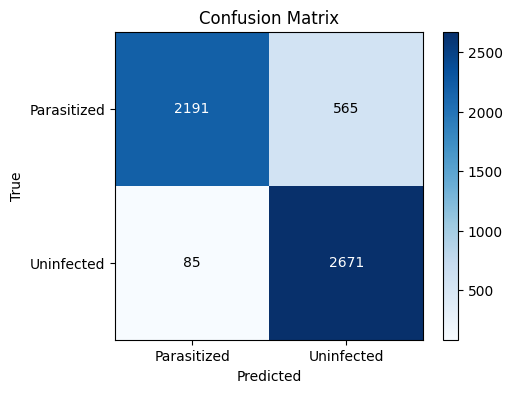

In [8]:
# Cell 8: Plot Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    plt.show()

plot_confusion_matrix(cm, ["Parasitized", "Uninfected"])

In [9]:
# Cell 9: Classification Report

from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=["Parasitized", "Uninfected"]
))

              precision    recall  f1-score   support

 Parasitized       0.96      0.79      0.87      2756
  Uninfected       0.83      0.97      0.89      2756

    accuracy                           0.88      5512
   macro avg       0.89      0.88      0.88      5512
weighted avg       0.89      0.88      0.88      5512



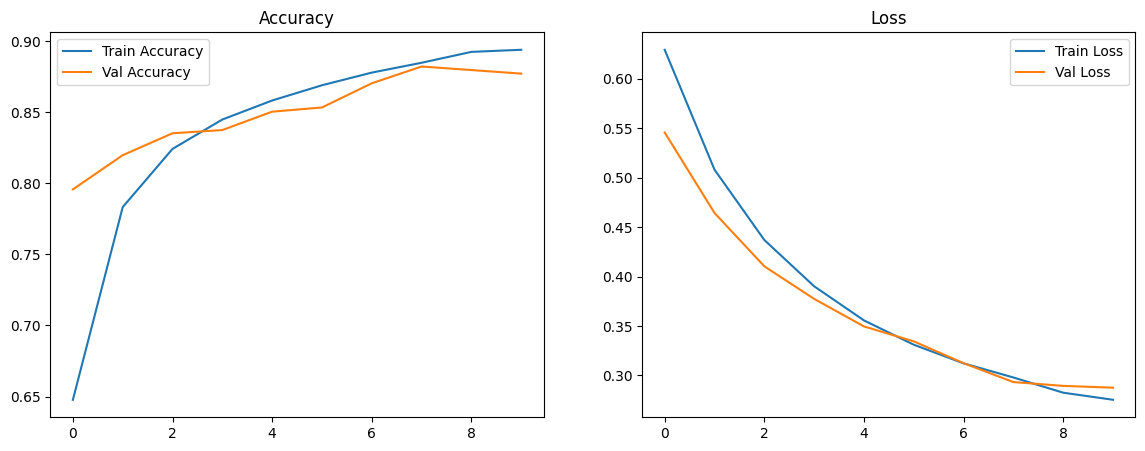

In [10]:
# ============================
# # Cell 10 — PLOT LOSS & ACCURACY
# ============================
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
# Save as TensorFlow SavedModel folder (for export/zip)
model.export("/kaggle/working/malaria_model_folder")

# Zip the folder
!zip -r /kaggle/working/malaria_model.zip /kaggle/working/malaria_model_folder


Saved artifact at '/kaggle/working/malaria_model_folder'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135041184505040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135041184506000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135041184505616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135042500365008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135041184506192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135042500362512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135042500366160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135042500364816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135039989271440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135039989272208: TensorSpec(shape=(), dtype=tf.resource, name=No